In [47]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(ggsci)
library(RColorBrewer)
Archr_col <- c('#D51F26','#272E6A','#208A42','#89288F','#F47D2B','#FEE500','#8A9FD1',
               '#C06CAB','#E6C2DC','#90D5E4','#89C75F','#F37B7D','#9983BD','#D24B27',
               '#3BBCA8','#6E4B9E','#0C727C','#7E1416','#D8A767')
colpalettes<-unique(c(pal_npg("nrc")(10),pal_aaas("default")(10),pal_nejm("default")(8),pal_lancet("lanonc")(9),
                      pal_jama("default")(7),pal_jco("default")(10),pal_ucscgb("default")(26),pal_d3("category10")(10),
                      pal_locuszoom("default")(7),pal_igv("default")(51),
                      pal_uchicago("default")(9),pal_startrek("uniform")(7),
                      pal_tron("legacy")(7),pal_futurama("planetexpress")(12),pal_rickandmorty("schwifty")(12),
                      pal_simpsons("springfield")(16),pal_gsea("default")(12)))

# Read data and convert it into a Seurat object, and register the spatial coordinates.

In [1]:
data_list = list.files('/gem_cut',full.names = T)

In [2]:
slice <- gsub(".*(T\\d+).*", "\\1", data_list)

In [4]:
matrix_list <- read.table("/mnt/SSD16Ta/huangzhi/Marmoset_Brain/Summary/celldata_raw/only-layer1-2d.txt",header=1)
trakem_transform <- function(x,y,matrix,matrix_bin,transform_bin){
    scale = matrix(c(transform_bin/matrix_bin,0,0,0,transform_bin/matrix_bin,0,0,0,1),ncol=3,nrow=3)
    matrix_t <- rbind(matrix(c(as.numeric(strsplit(matrix,',')[[1]])),nrow=2),c(0,0,1))
    matrix_t <- solve(scale) %*% matrix_t %*% scale
    coor_matrix <- cbind(x,y,1)
    coor_matrix_t <- t(matrix_t %*% t(coor_matrix))
    rx <- coor_matrix_t[,1]
    ry <- coor_matrix_t[,2]
    return(list('rx'=rx, 'ry'=ry))
    }
creat_region_layer_obj <- function(gem,bin,sample){
    coor_t <- trakem_transform(gem$x,gem$y,matrix_list[matrix_list$title==sample,'matrix'],matrix_bin=50,transform_bin=1)
    gem$region <- c('1'='Pu','2'='GP','3'='Cd')[as.character(gem$mask)]
    gem$x <- coor_t$rx
    gem$y <- coor_t$ry
    gem$x <- round(gem$x/bin,0)
    gem$y <- round(gem$y/bin,0)
    gem$label <- paste0(sample,"_",gem$x,"_",gem$y)
    gem$geneID <- gem$gene
    gem$MIDCount <- gem$umi_count
    
    gene=1:length(unique(gem$geneID))
    names(gene)=unique(gem$geneID)
    cell=1:length(unique(gem$label))
    names(cell)=unique(gem$label)
    mat1=sparseMatrix(i = gene[gem$geneID],j=cell[ as.character(gem$label) ], x=gem$MIDCount)
    rownames(mat1)=names(gene)
    colnames(mat1)=names(cell)
    obj2=CreateSeuratObject(counts = mat1)

    region <- aggregate(gem$region,by=list('label'=gem$label),FUN=function(x){names(sort(table(x),decreasing = T))[1]})
    rownames(region) <- region$label
    obj2@meta.data$region <- region[rownames(obj2@meta.data),2]
    return(obj2)
}



In [ ]:

obj.list <- sapply(c(1:length(data_list)),function(i){
    mat2 <- data.table::fread(data_list[i])
    mat2 <- as.data.frame(mat2)
    obj <- creat_region_layer_obj(mat2,200,slice[i])
    return(obj)
    })

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with da

In [8]:
for (i in c(1:length(obj.list))){
    obj.list[[i]]$x =as.numeric(gsub("[^0-9]+", "", sub(".*_([0-9]+)_.*", "\\1", rownames(obj.list[[i]]@meta.data)))) 
    obj.list[[i]]$y =as.numeric(gsub("[^0-9]+", "", sub(".*_([0-9]+)$", "\\1", rownames(obj.list[[i]]@meta.data)))) 
}

# Integrate all slices

In [9]:
for (i in 1:length(obj.list)) {
    obj.list[[i]] <- obj.list[[i]]
    obj.list[[i]] <- NormalizeData(obj.list[[i]], verbose = FALSE)
    obj.list[[i]] <- FindVariableFeatures(object = obj.list[[i]],nfeatures = 8000)
    obj.list[[i]] <- ScaleData(object = obj.list[[i]],verbose = F,vars.to.regress = 'nCount_RNA')
    obj.list[[i]] <- RunPCA(object = obj.list[[i]],verbose = F)
}
reference.seq = seq(from=1,by=3,length=15)
features <- SelectIntegrationFeatures(object.list = obj.list,nfeatures = 5000)
obj.anchors <- FindIntegrationAnchors(object.list = obj.list, anchor.features = features,reference = reference.seq, reduction = "rpca")

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.1004”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  6.4094e-16”
Scaling features for provided objects

Computing within dataset neighborhoods

Finding anchors between all query and reference datasets

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 150 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 112 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 203 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 274 anchors

Projectin

In [10]:
obj_tha <- IntegrateData(anchorset = obj.anchors,k.weight = min(table(paste0(obj.anchors@anchors$dataset1,'_',obj.anchors@anchors$dataset2)))-1)

Building integrated reference

Merging dataset 37 into 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 34 into 19

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 31 into 13

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 43 into 4 37

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 40 into 16

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 28 into 4 37 43

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 13 31 into 4 37 43 28

Extracting anchors for m

In [12]:
obj_tha <- ScaleData(obj_tha, verbose = FALSE) 
obj_tha <- RunPCA(obj_tha, npcs = 15, verbose = FALSE)
obj_tha <- FindNeighbors(obj_tha, dims = 1:15)
obj_tha <- FindClusters(obj_tha, resolution = c(0.1,0.5))
obj_tha <- RunUMAP(obj_tha, dims = 1:15)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 56695
Number of edges: 1829594

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9522
Number of communities: 11
Elapsed time: 22 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 56695
Number of edges: 1829594

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8993
Number of communities: 22
Elapsed time: 19 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:17:36 UMAP embedding parameters a = 0.9922 b = 1.112

11:17:36 Read 56695 rows and found 15 numeric columns

11:17:36 Using Annoy for neighbor search, n_neighbors = 30

11:17:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:17:41 Writing NN index file to temp file /tmp/RtmpvceRfM/file152a9e32120984

11:17:41 Searching Annoy index using 1 thread, search_k = 3000

11:18:06 Annoy recall = 100%

11:18:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbor

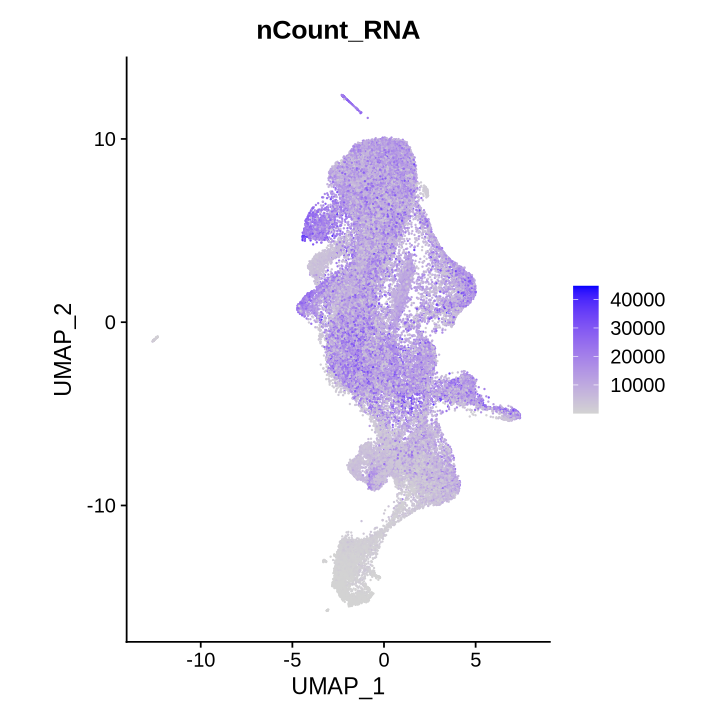

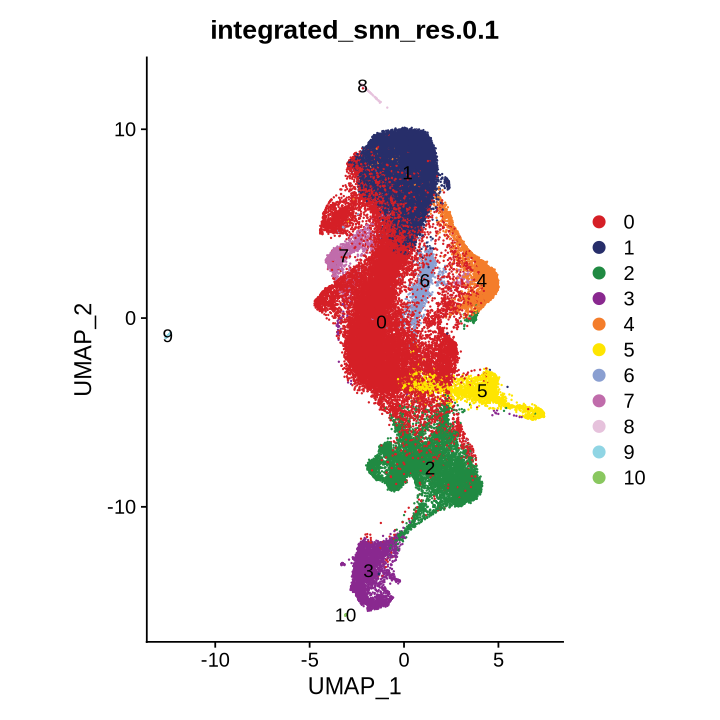

In [22]:
options(repr.plot.width=6,repr.plot.height=6)
FeaturePlot(obj_tha,reduction = 'umap',features='nCount_RNA')+coord_fixed()
DimPlot(obj_tha,reduction = 'umap',group.by='integrated_snn_res.0.1',cols = Archr_col,label = T)+coord_fixed()#+NoLegend()+

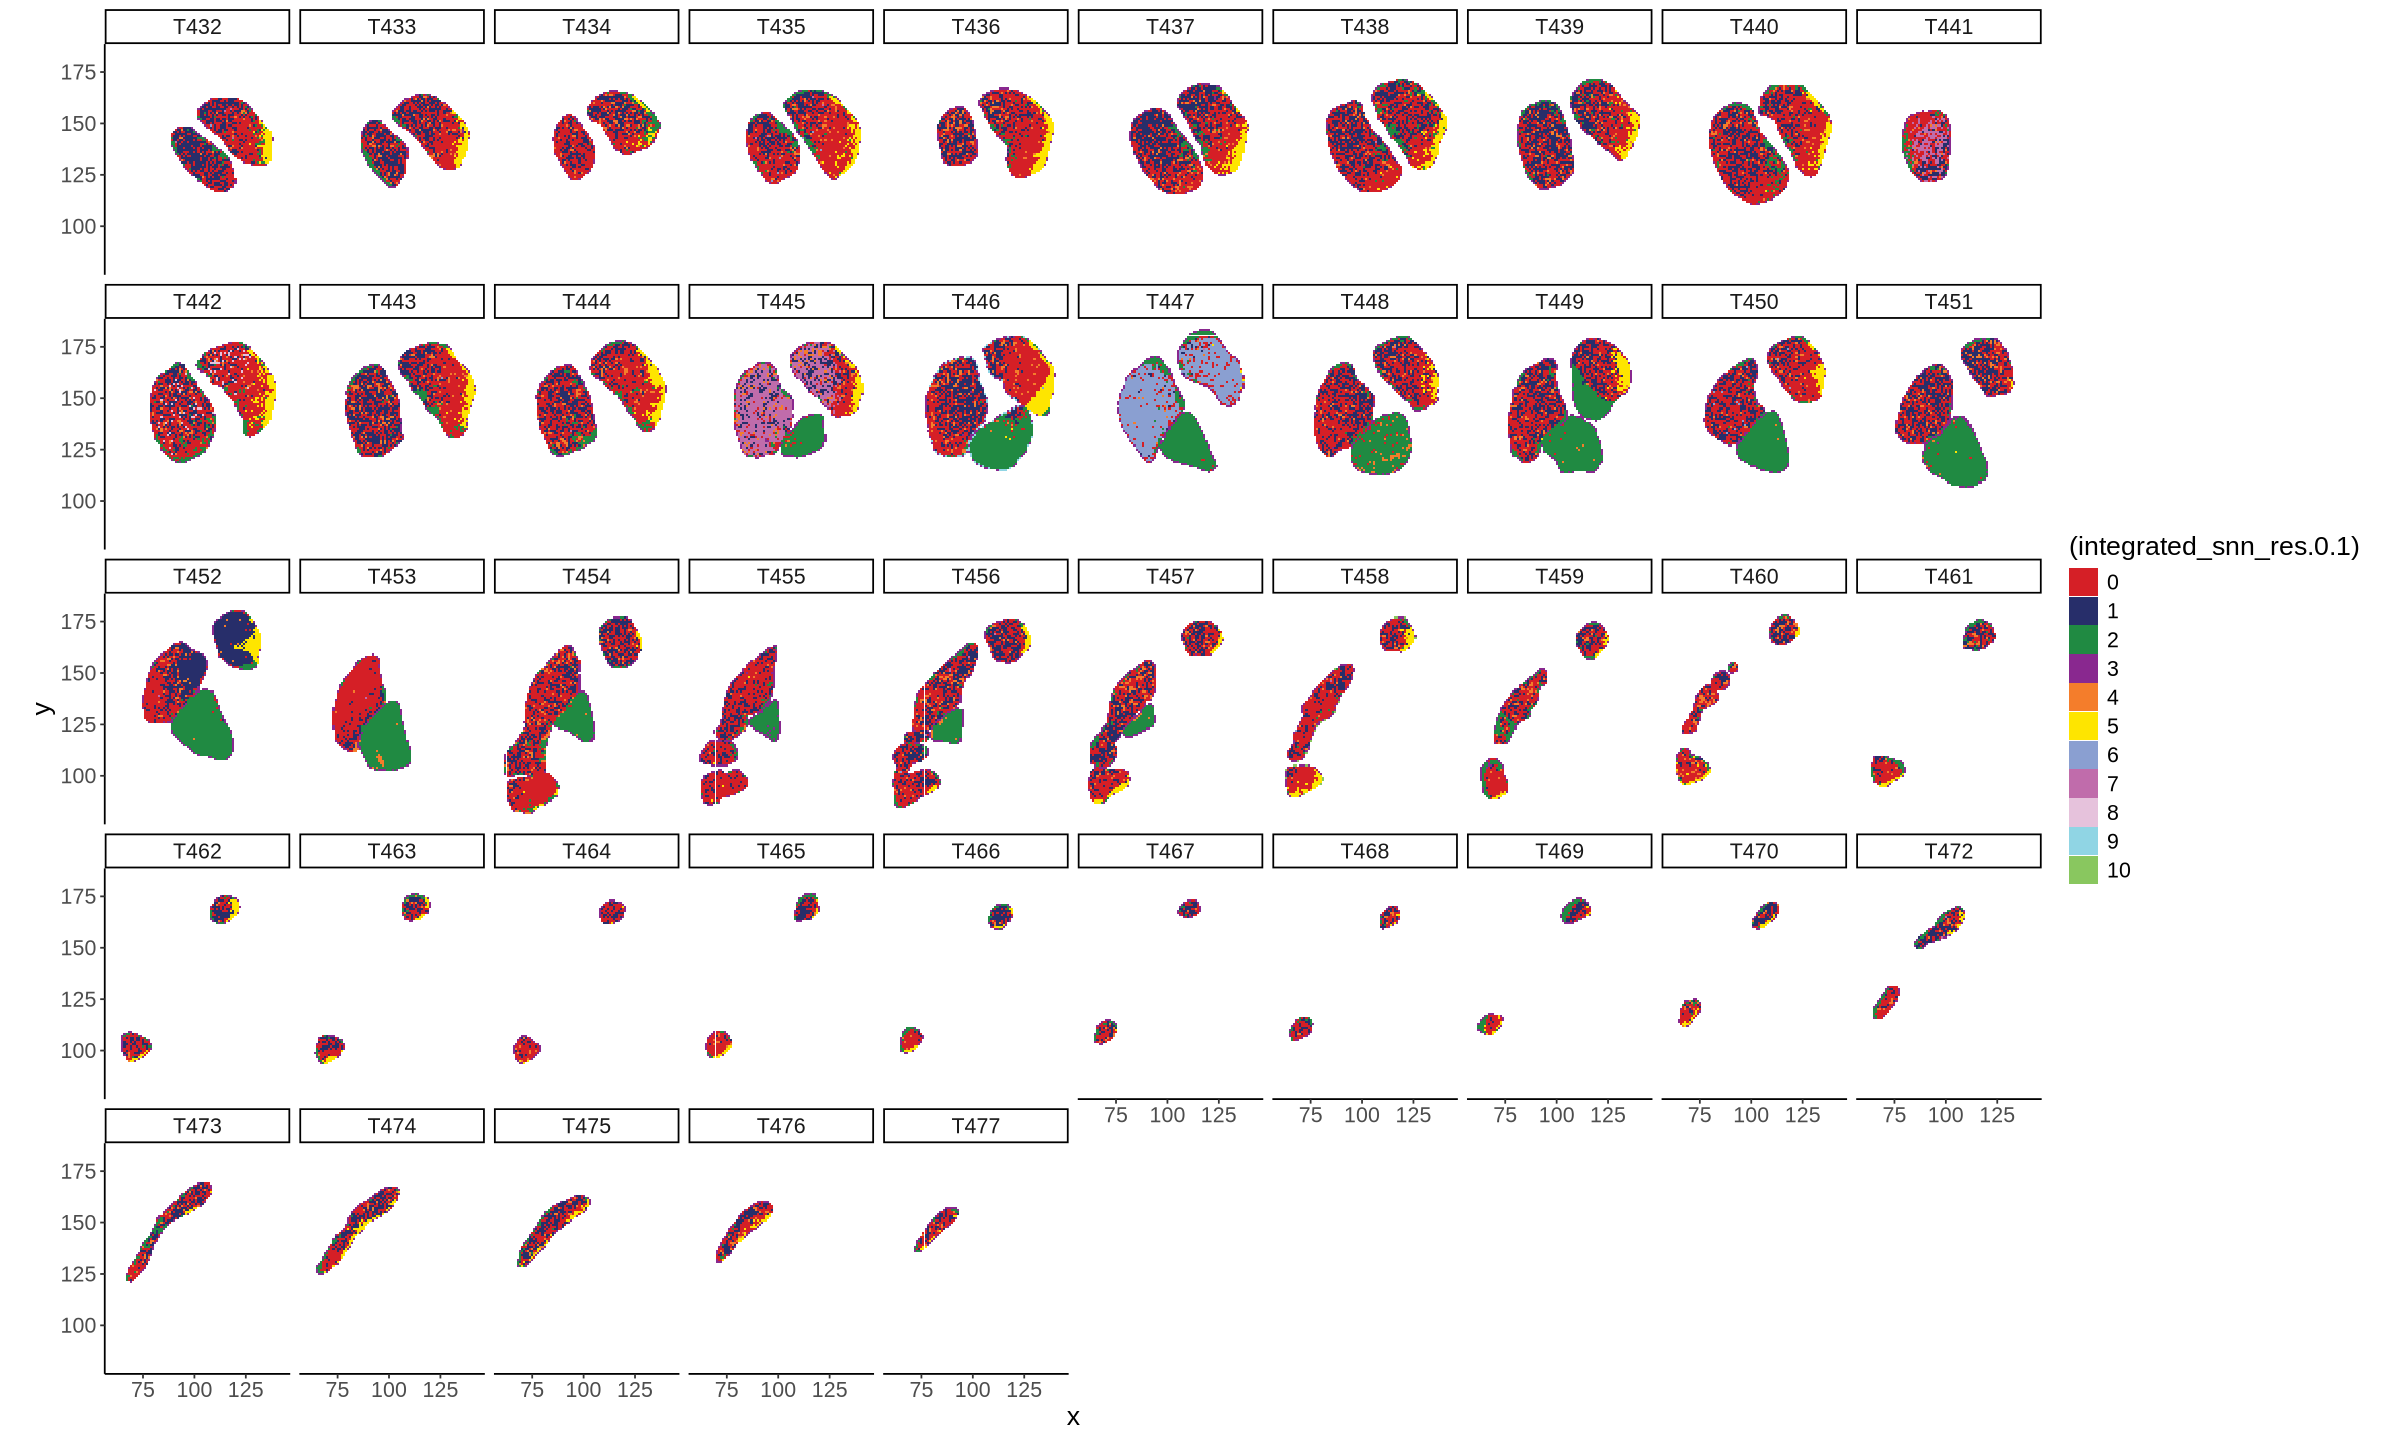

In [26]:
options(repr.plot.width=20,repr.plot.height=12)
ggplot()+
geom_tile(data=obj_tha@meta.data,aes(x=x,y=y,fill=(integrated_snn_res.0.1)))+
facet_wrap(~orig.ident,ncol=10)+
#scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
scale_fill_manual(values = Archr_col)+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()

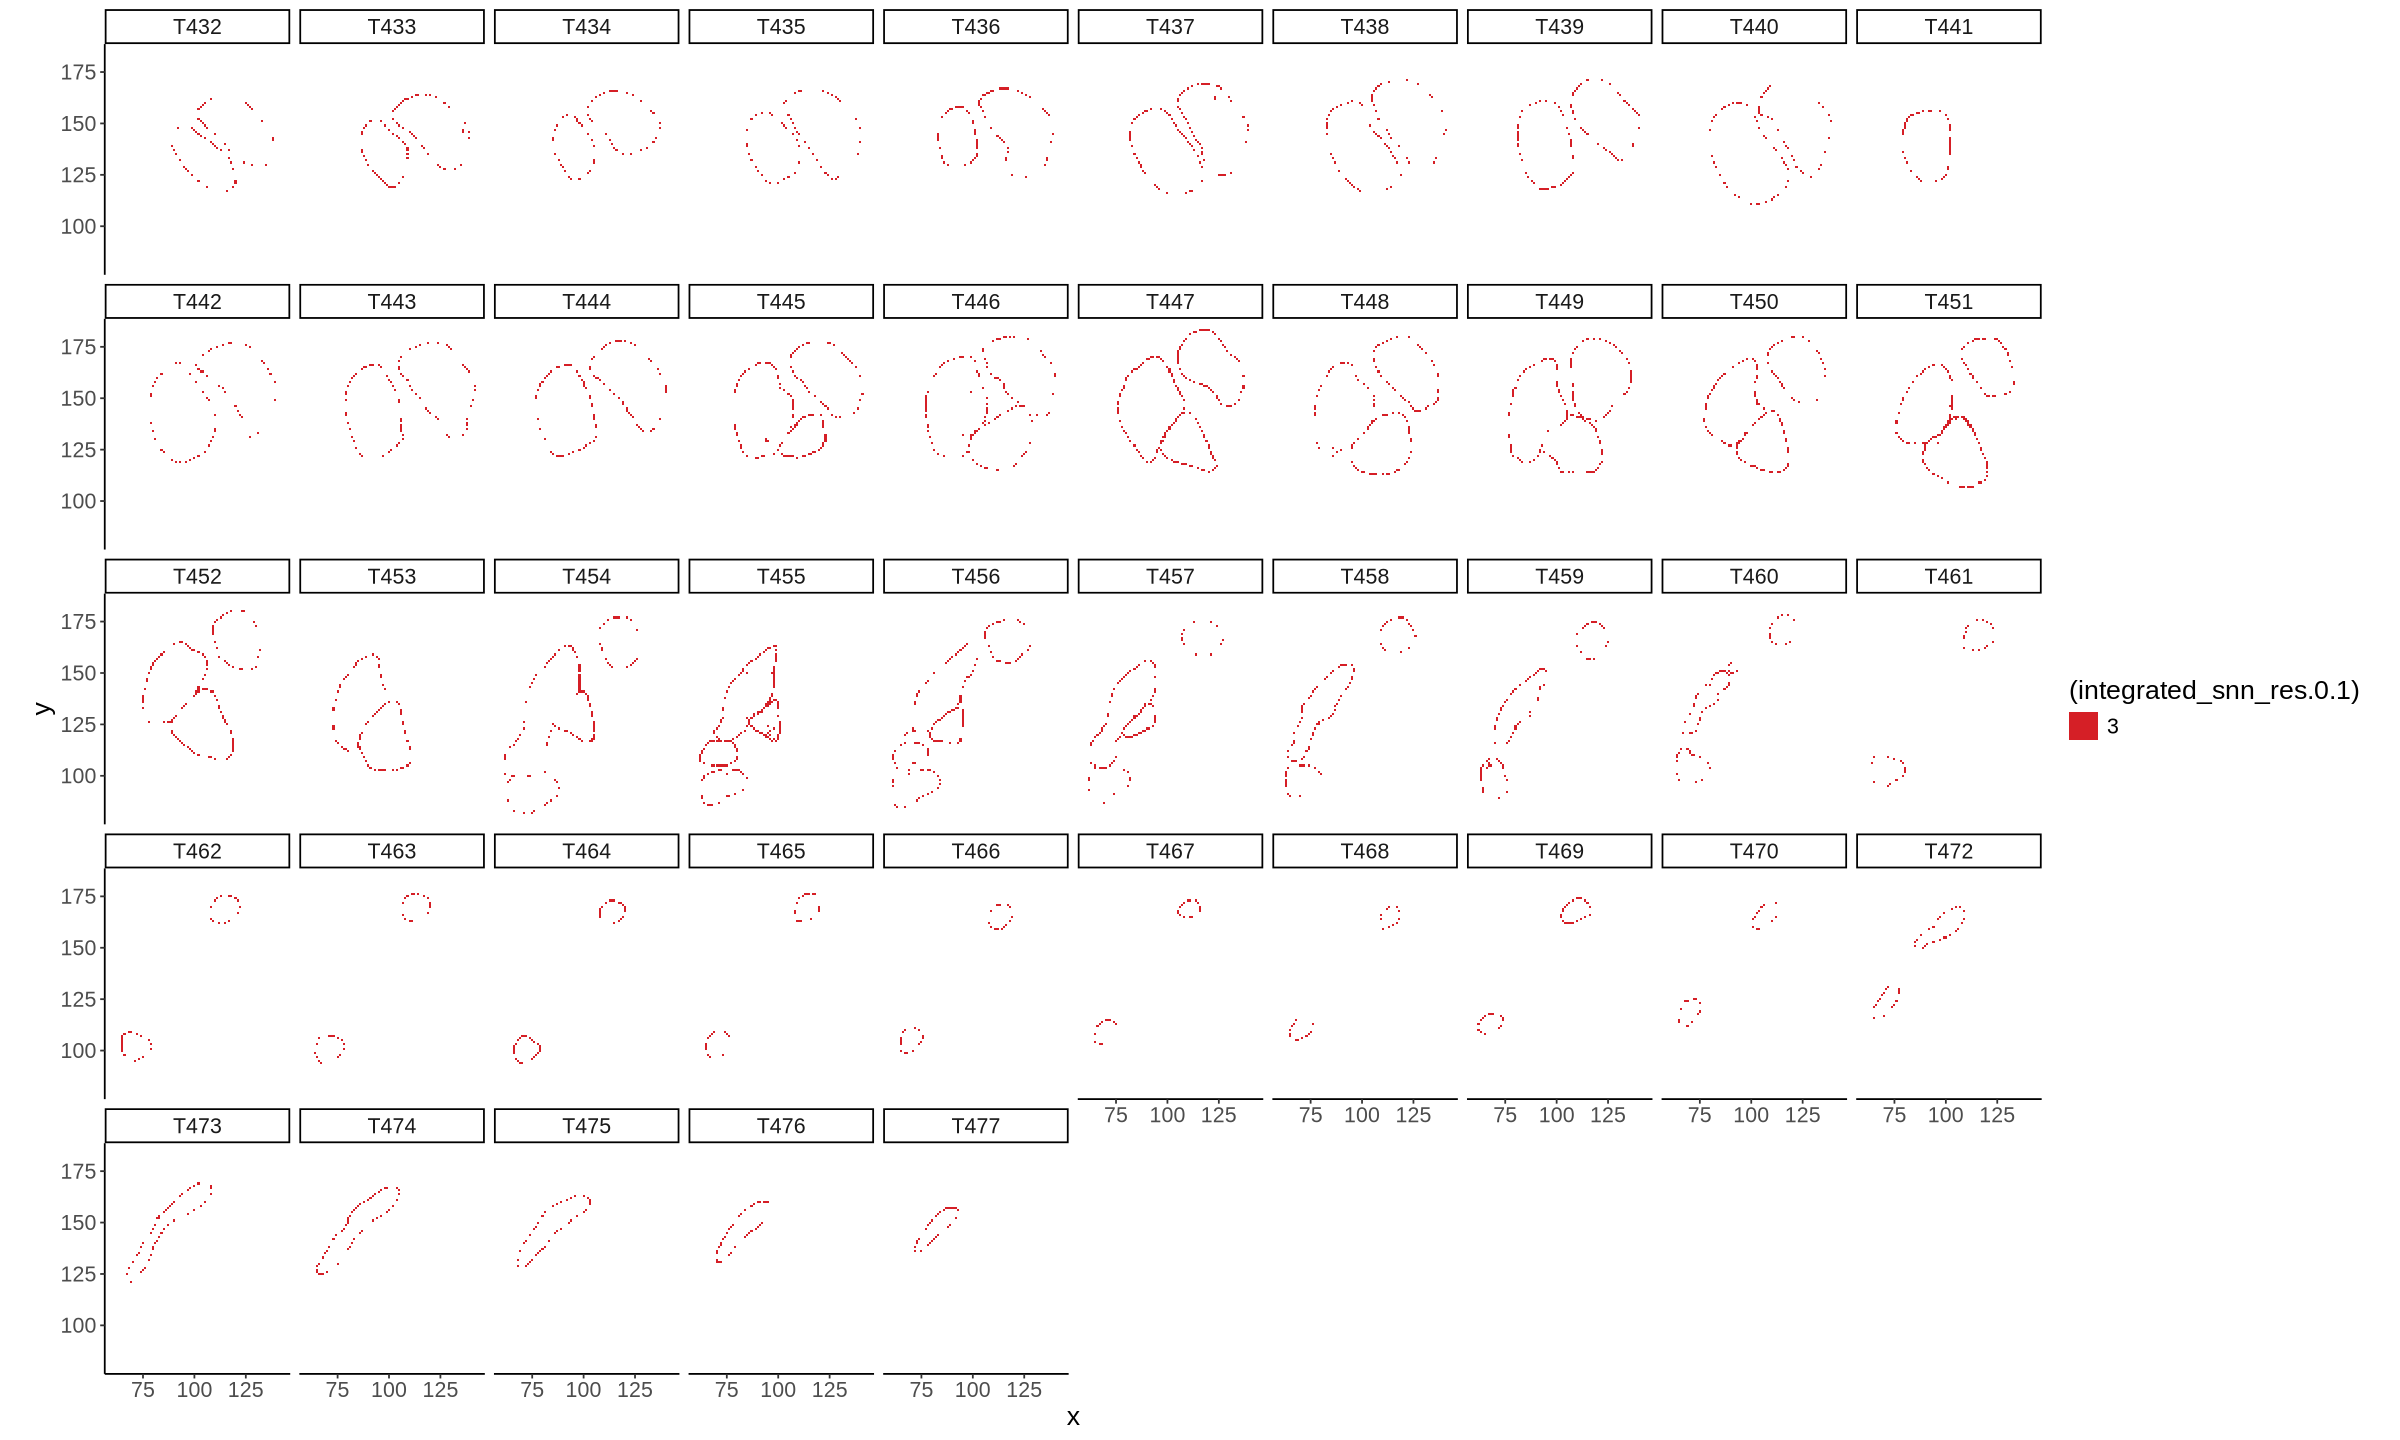

In [27]:
options(repr.plot.width=20,repr.plot.height=12)
ggplot()+
geom_tile(data=obj_tha@meta.data[obj_tha$integrated_snn_res.0.1 == '3',],aes(x=x,y=y,fill=(integrated_snn_res.0.1)))+
facet_wrap(~orig.ident,ncol=10)+
#scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
scale_fill_manual(values = Archr_col)+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()

In [ ]:
### Remove clusters with too low expression levels (boundaries), remove GP, and remove poorly - quality slides
Idents(obj_tha) = obj_tha$integrated_snn_res.0.1
obj = subset(obj_tha,idents =c(0,1,2,4,5,6,7,8,9,10))


In [31]:
Idents(obj) = obj$region
obj = subset(obj,idents=c('Cd','Pu'))
sample = c(slice[1:9],slice[11:21],slice[23:45])
Idents(obj) = obj$orig.ident
obj = subset(obj,idents =sample )

# Calculate the PCA for all slides

In [35]:
source('knn_function.r')

In [36]:
obj$z <- as.numeric(gsub('T','',obj$orig.ident))*1e5
result <- nn2(obj@meta.data[,c('x','y','z')],obj@meta.data[,c('x','y','z')],k=50)
smooth_kNN2 <- function(sm_vector,result){
    for(i in 1:2){
        if(i==1){initail_col <- sm_vector}else{initail_col <- sm_vector_sm}
        sm_vector_sm <- rowMeans(matrix(initail_col[result$nn.idx],nrow = nrow(result$nn.idx), byrow = FALSE))
    }
    return(sm_vector_sm)
}
#obj_tha@active.assay <- 'RNA'
#obj_tha <- NormalizeData(obj_tha)
data_matrix <- as.matrix(obj@assays$integrated@data)
pb <- txtProgressBar(style=3)
n <- 1
all_n <- nrow(data_matrix)
for(i in rownames(data_matrix)){
    data_matrix[i,] <- smooth_kNN2(data_matrix[i,],result)
    setTxtProgressBar(pb, n/all_n)
    n <- n+1}
close(pb)
data_matrix <- CreateAssayObject(data=data_matrix)
obj[['imputation']] <- data_matrix

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.7 GiB”


  |======================================================================| 100%


In [38]:
DefaultAssay(obj) = 'imputation'
obj <- FindVariableFeatures(obj)
obj <- ScaleData(obj, verbose = FALSE,features = rownames(obj)) 
obj <- RunPCA(obj, npcs = 15, verbose = FALSE)

Warning message in FindVariableFeatures.Assay(object = assay.data, selection.method = selection.method, :
“selection.method set to 'vst' but count slot is empty; will use data slot instead”
Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of items to replace is not a multiple of replacement length”


In [ ]:
### Read genes with conserved patterns in the cortex and thalamus
gene = read.csv("Tha_PC1_gene.csv")
p_gene = gene[gene$c_type == 'Pr_Tha-P','X']
n_gene = gene[gene$c_type == 'Al_Tha-N','X']

In [40]:
obj <- AddModuleScore(obj,features = list(p_gene),name='p')
obj <- AddModuleScore(obj,features = list(n_gene),name='n')

Warning message:
“The following features are not present in the object: LOC108593711, PHC2, CDKN2A, KDM7A, CKAP4, HSD17B1, GRIPAP1, IFFO1, ESYT1, ENO2, FBXO32, SENP5, LOC118146909, SSTR3, DNAJC13, LOC100410236, HELT, ANKRD24, ADAP1, LOC108593350, LSM12, LOC118152919, USP2, SRXN1, LOC118147820, MYH14, NUDT18, OSGEPL1, SYT12, UBXN2A, APC, LOC103790533, AGPAT3, IDH3A, UBP1, SPOUT1, BRSK1, ERRFI1, FAM131C, LOC100406488, LOC118153924, BICDL1, HMGXB3, NDE1, GNGT2, RTN2, PLAUR, LOC100412761, FAM102A, TRIM37, VPS33A, MAPK9, ZNF280D, RNF146, PANK1, MYO18A, MAP1A, UBL4A, STC2, MAPK8IP3, RC3H1, CACNG7, ANKRD29, SMIM13, LOC108588103, TWSG1, TRIP12, LOC118149884, MICU3, TRIM65, KLF9, MPC1, DENND5B, OSBPL2, HUWE1, FAM171A1, WASL, KDM2A, ATP2A2, LOC100404418, RBM3, ZNF343, KIAA1841, ETV4, SESN2, DMTN, PNPLA7, TMCC2, RIMS4, ENDOG, ZDHHC20, PPP3CB, COQ9, KLHL42, NARS1, PPP2R1A, PLEKHH1, BEND6, ORAI3, DPP8, SIRT5, LOC118150254, ST8SIA1, EML2, MRPS9, UBE2QL1, AATK, LOC103789237, MTFP1, SLC6A8, LOC1085879

In [41]:
obj@meta.data[,c('PC_1','PC_2','PC_3')] = obj@reductions$pca@cell.embeddings[,c('PC_1','PC_2','PC_3')]

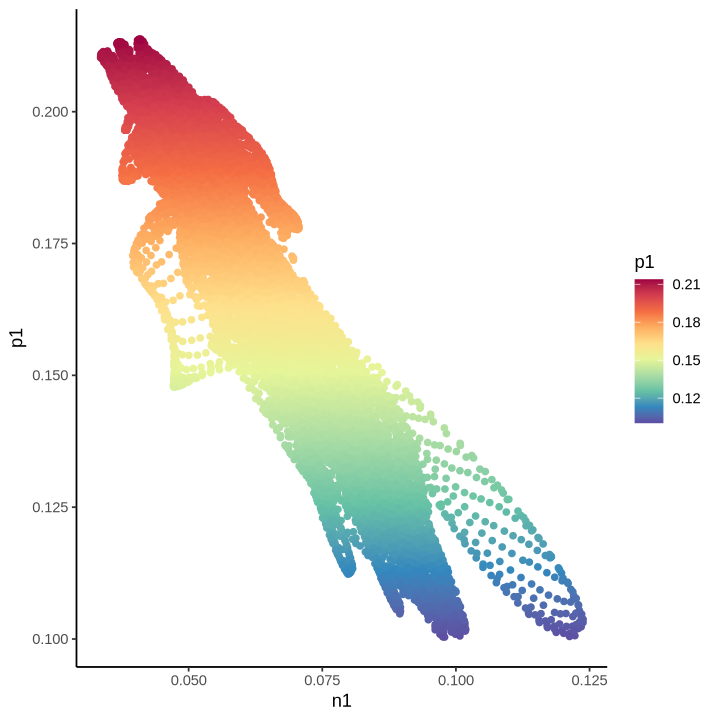

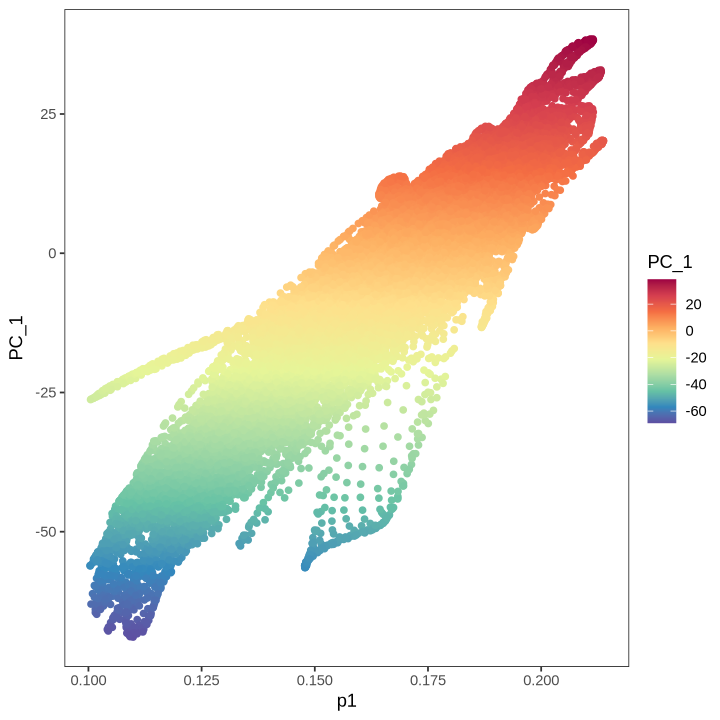

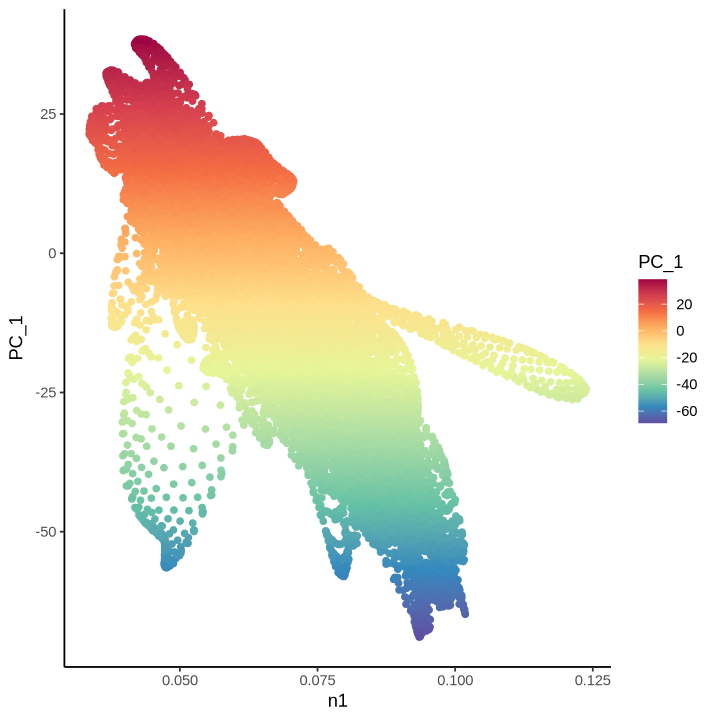

In [ ]:
### 
options(repr.plot.width=6,repr.plot.height=6)
ggplot(data = obj@meta.data,aes(x=n1,y=p1,color = p1))+
geom_point()+
scale_color_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()

ggplot(data = obj@meta.data,aes(x=p1,y=PC_1,color = PC_1))+
geom_point()+
scale_color_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_test()
ggplot(data = obj@meta.data,aes(x=n1,y=PC_1,color = PC_1))+
geom_point()+
scale_color_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()


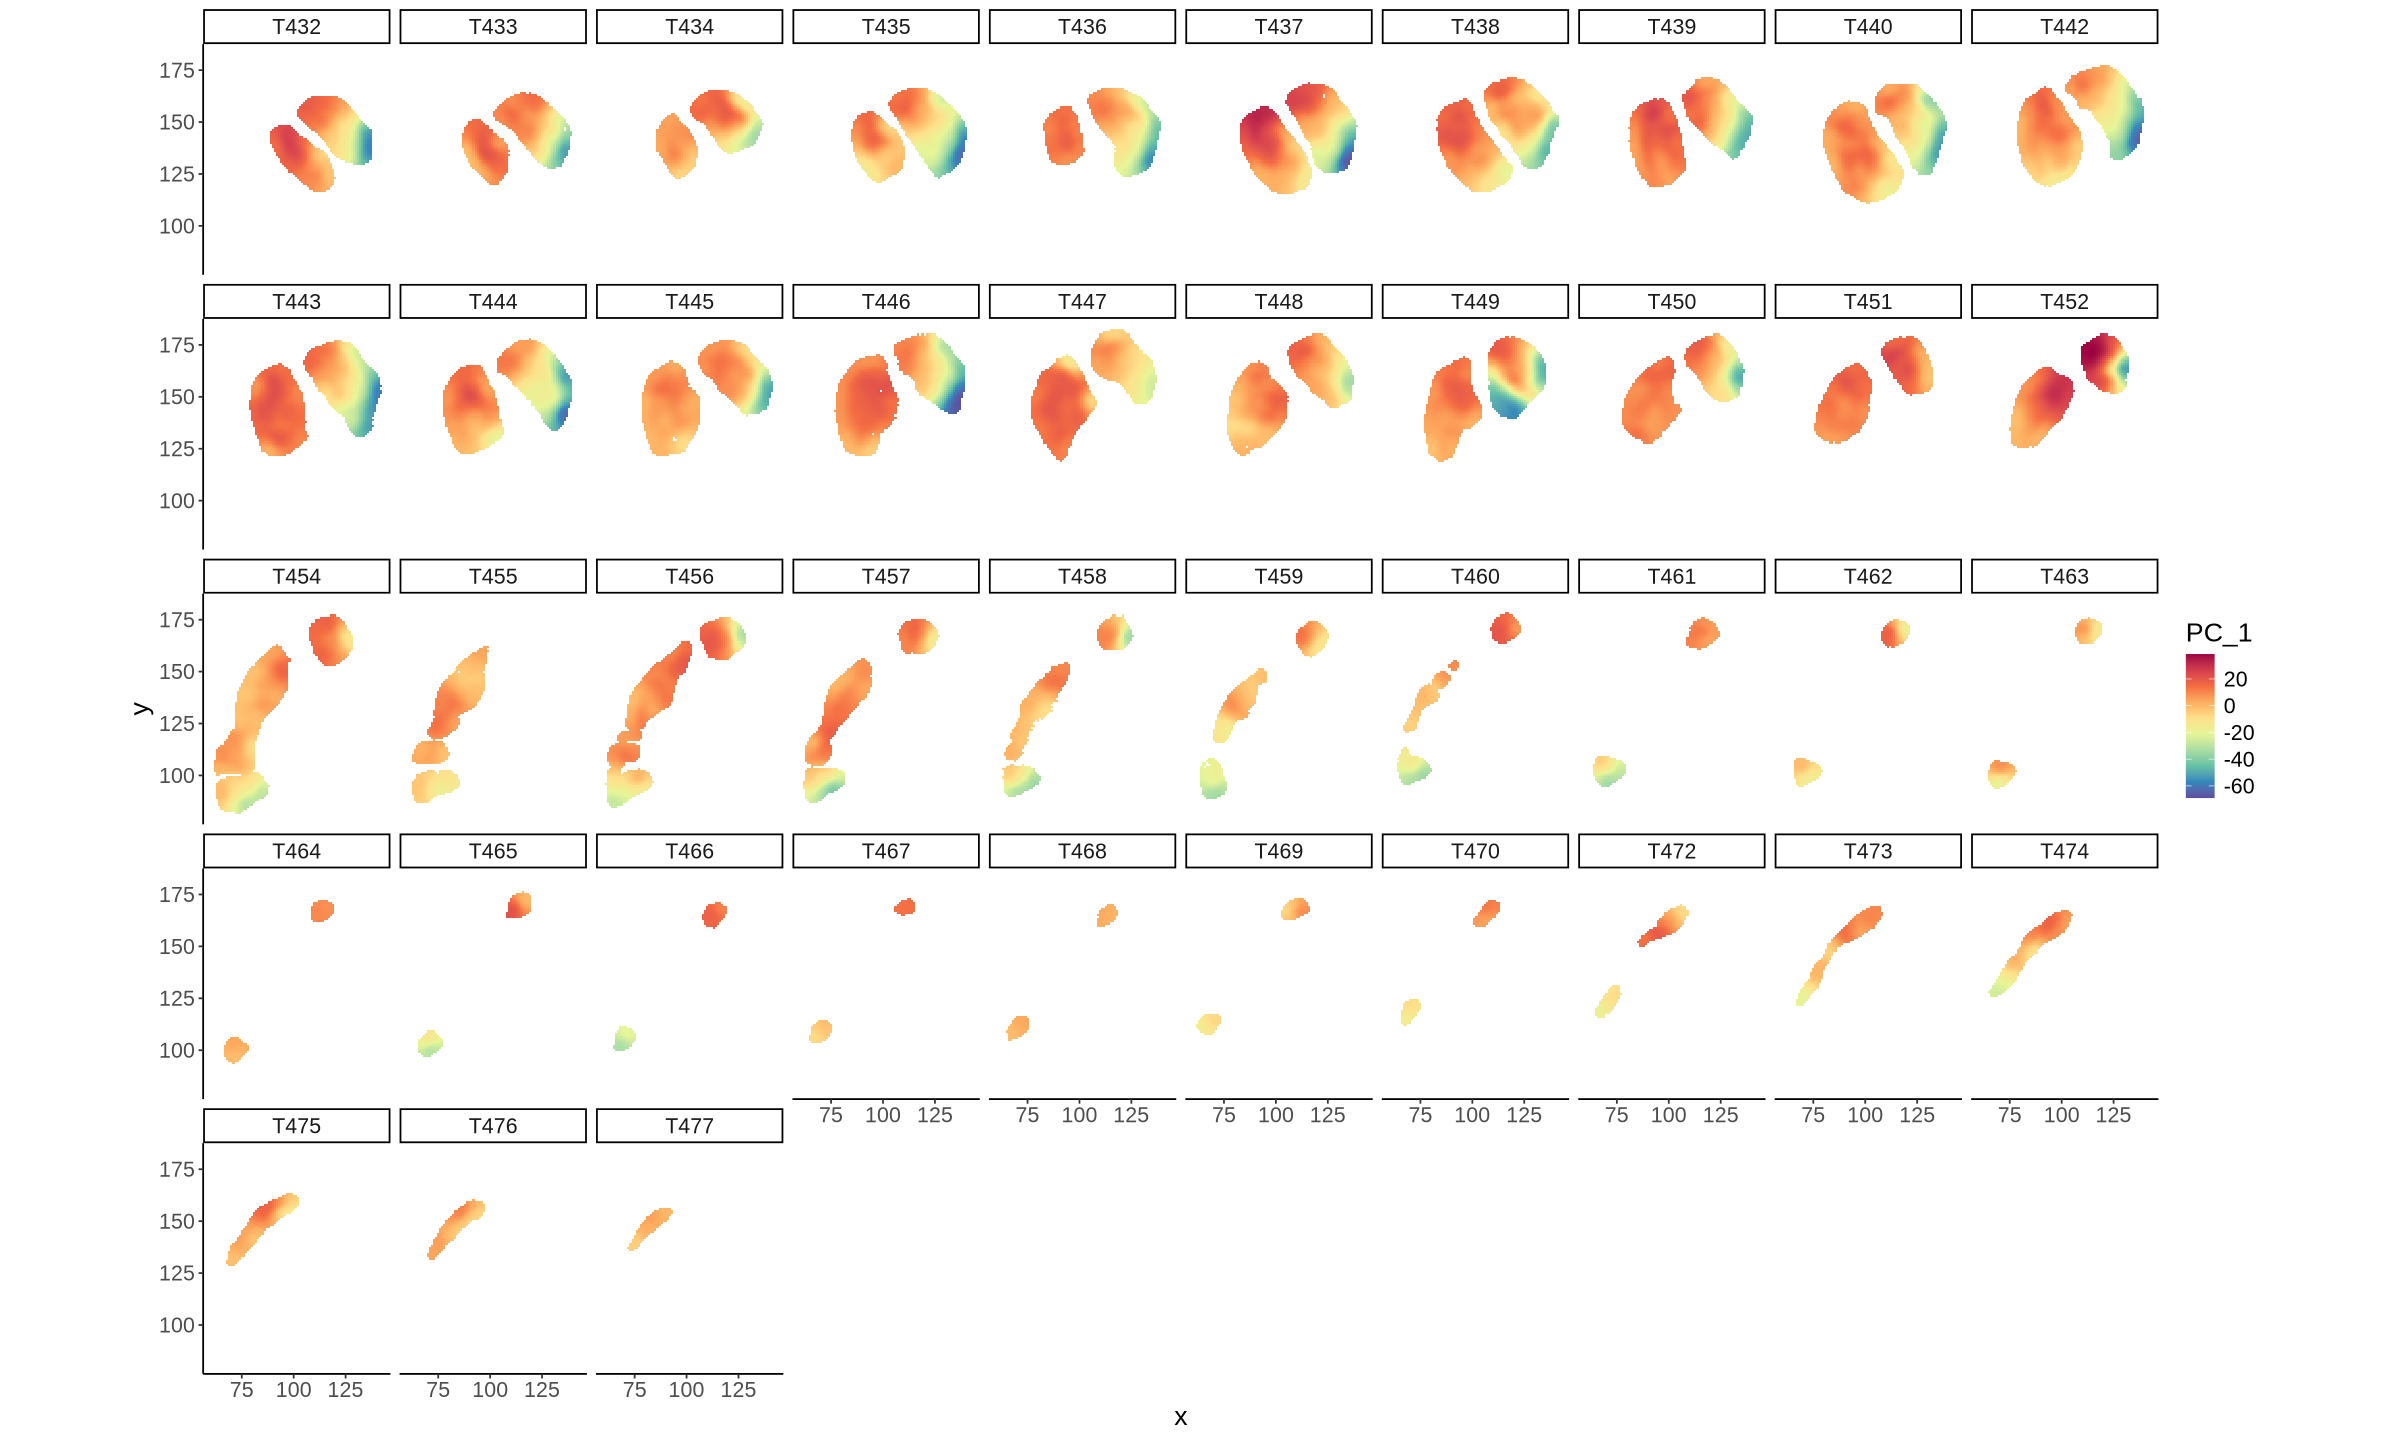

In [51]:
obj$PC_1 = -obj$PC_1
options(repr.plot.width=20,repr.plot.height=12)
ggplot()+
geom_tile(data=obj@meta.data,aes(x=x,y=y,fill=PC_1))+
facet_wrap(~orig.ident,ncol=10)+
scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()

# Impute all genes

In [58]:
obj@active.assay='RNA'
obj = NormalizeData(obj)

In [61]:

data_matrix <- as.matrix(obj@assays$RNA@data)
pb <- txtProgressBar(style=3)
n <- 1
all_n <- nrow(data_matrix)
for(i in rownames(data_matrix)){
    data_matrix[i,] <- smooth_kNN2(data_matrix[i,],result)
    setTxtProgressBar(pb, n/all_n)
    n <- n+1}
close(pb)
data_matrix <- CreateAssayObject(data=data_matrix)
obj[['imputation_RNA']] <- data_matrix

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 11.0 GiB”


  |======================================================================| 100%


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from imputation_rna_ to imputationrna_”


In [62]:
cor_test_wrapper <- function(x, y) {
  test_result <- cor.test(x, y)
  return(c(cor = test_result$estimate, p_value = test_result$p.value))
}
tred = 0
mat = as.matrix(obj@assays$imputation_RNA@data)
pc1 =as.matrix(as.data.frame(obj@meta.data[,'PC_1']))
result_2 <- t(apply(mat, 1, cor_test_wrapper, y = pc1[,1]))
result_2 = as.data.frame(result_2)
result_2$gene = rownames(result_2)


Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation is zero”
Warning message in cor(x, y):
“the standard deviation i

In [63]:
result_2[is.na(result_2$cor.cor),'cor.cor']=0
result_2[is.na(result_2$p_value),'p_value']=1
result_2[result_2$p_value < 0.05&result_2$cor.cor > tred,'type'] = 'Pr'
result_2[result_2$p_value < 0.05&result_2$cor.cor < -tred,'type'] = 'Al'
result_2[!((result_2$p_value < 0.05&result_2$cor.cor > tred)|(result_2$p_value < 0.05&result_2$cor.cor < -tred)),'type'] = 'Other'

In [66]:
head(result_2)

,cor.cor,p_value,gene,type
,<dbl>,<dbl>,<chr>,<chr>
CCDC153,0.02167613,3.313863e-06,CCDC153,Pr
LOC118145026,-0.06562647,4.201099e-45,LOC118145026,Al
LOC103795996,0.04808978,5.615024e-25,LOC103795996,Pr
LOC118151414,0.04291686,3.248087e-20,LOC118151414,Pr
LOC118144972,-0.04376580,5.842604e-21,LOC118144972,Al
MPC1,-0.39091901,0.000000e+00,MPC1,Al


In [67]:
obj@active.assay='imputation_RNA'

In [ ]:
### AddModuleScore of conserved genes in Pr and Al
obj <- AddModuleScore(obj,features = list(p_gene),name='p')
obj <- AddModuleScore(obj,features = list(n_gene),name='n')

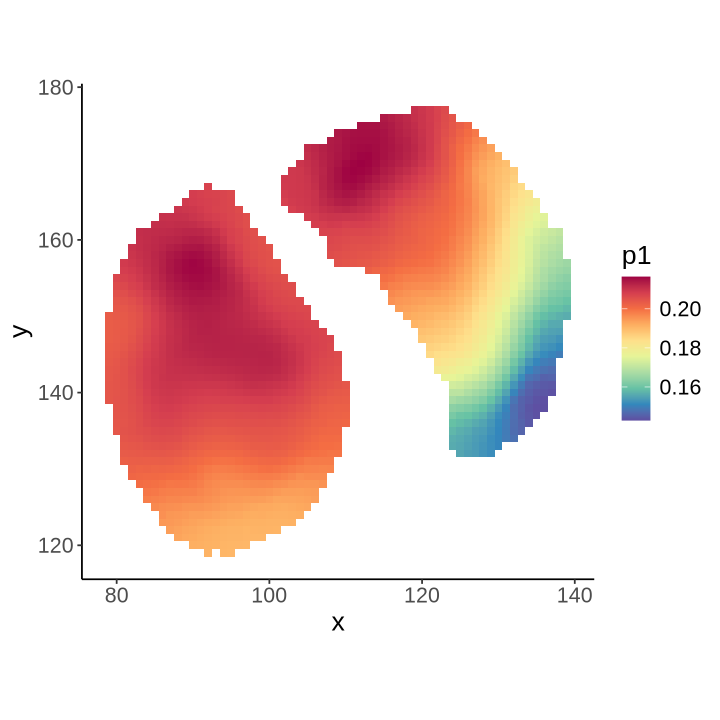

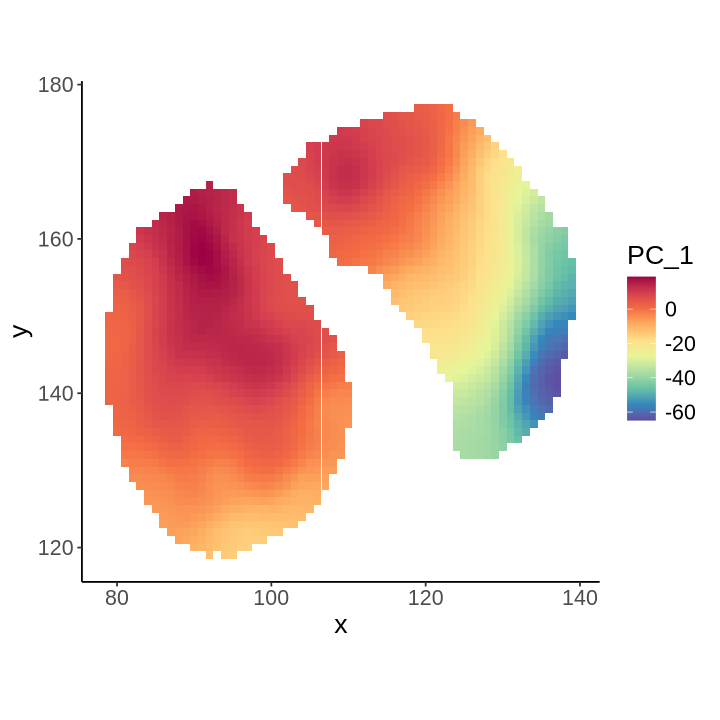

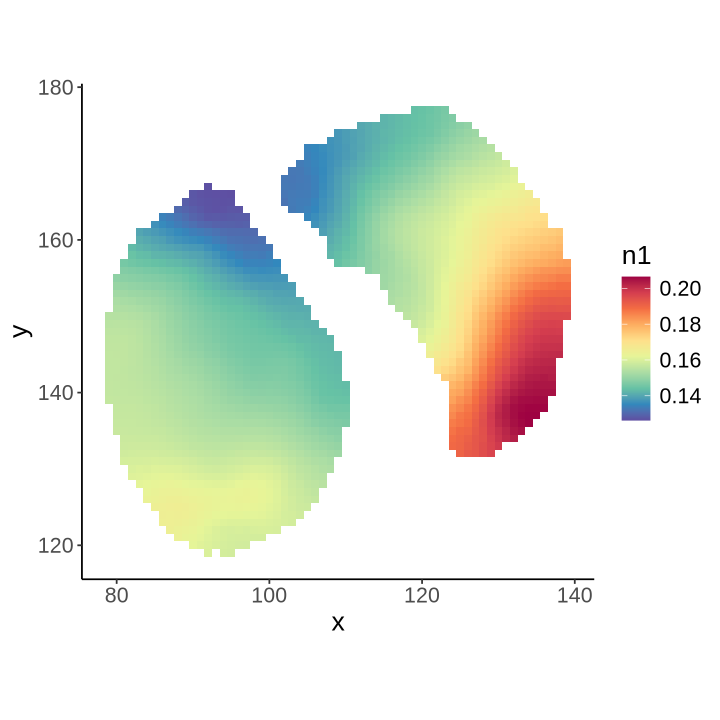

In [70]:
ggplot()+
geom_tile(data=obj@meta.data[obj$orig.ident == 'T442',],aes(x=x,y=y,fill=p1))+
#facet_wrap(~orig.ident,ncol=10)+
scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()
ggplot()+
geom_tile(data=obj@meta.data[obj$orig.ident == 'T442',],aes(x=x,y=y,fill=PC_1))+
#facet_wrap(~orig.ident,ncol=10)+
scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()
ggplot()+
geom_tile(data=obj@meta.data[obj$orig.ident == 'T442',],aes(x=x,y=y,fill=n1))+
#facet_wrap(~orig.ident,ncol=10)+
scale_fill_gradientn(colours = rev(RColorBrewer::brewer.pal(11,'Spectral')[-6]))+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()

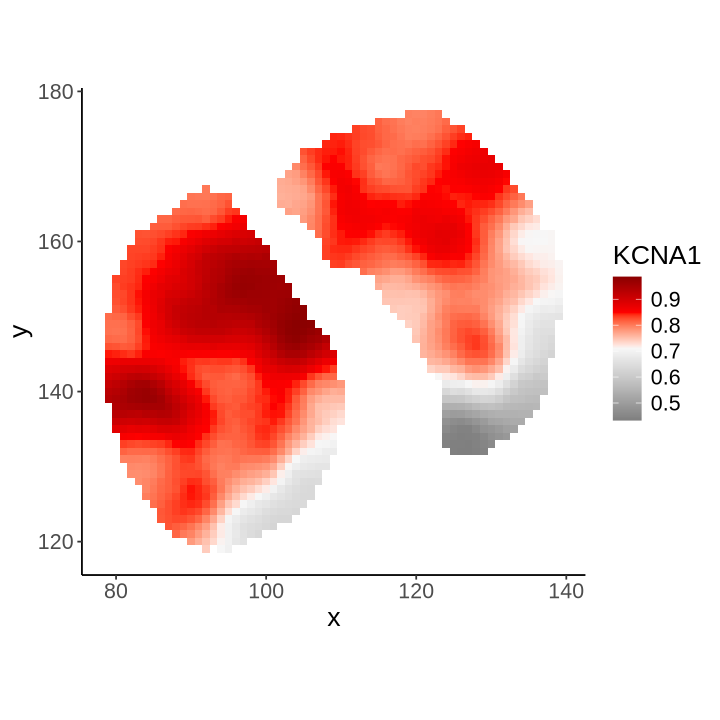

In [71]:
plot = obj@meta.data
gene = 'KCNA1'
plot$gene = obj@assays$imputation_RNA@data[gene,]
plot = plot[plot$orig.ident == 'T442',]

options(repr.plot.width=6,repr.plot.height=6)
ggplot()+
geom_tile(data=plot,aes(x=x,y=y,fill=gene))+
#facet_wrap(~orig.ident,ncol=10)+
scale_fill_gradientn(colours = c('gray50','gray','gray97','red','darkred'),name=gene)+
theme_classic()+
theme(text = element_text(size=16))+
coord_fixed()